# Titanic Survival Prediction: Random Forest vs. KNN

In [1]:
import pandas as pd #pandas: For data manipulation and loading the dataset.
from sklearn.impute import SimpleImputer #SimpleImputer: Used for imputing missing values in the data (filling missing values).
from sklearn.preprocessing import StandardScaler, OneHotEncoder #StandardScaler: Standardizes numerical features by scaling them to have zero mean and unit variance.
                                                                #OneHotEncoder: Encodes categorical variables into numerical data by creating binary columns for each category.
from sklearn.compose import ColumnTransformer #ColumnTransformer: Allows applying different preprocessing pipelines to numerical and categorical features in a single step
from sklearn.pipeline import Pipeline #Pipeline: Chains preprocessing steps and model training into a single step.
from sklearn.model_selection import train_test_split #train_test_split: Splits the data into training and testing sets.
from sklearn.ensemble import RandomForestClassifier #RandomForestClassifier: A machine learning model used for classification tasks.
from sklearn.metrics import accuracy_score, classification_report #accuracy_score and classification_report: Metrics for model evaluation.
from sklearn.utils import resample #accuracy_score and classification_report: Metrics for model evaluation.
from sklearn.neighbors import KNeighborsClassifier #KNeighborsClassifier: A machine learning model used for classification tasks.

In [2]:
# Load the dataset
df = pd.read_csv('titanic_data.csv', keep_default_na=False)

# Feature engineering: Extract title from the "Name" column
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Separate features and target
attributes = df.drop('Survived', axis=1)
target = df['Survived']

# Identify numerical and categorical columns
numeric_features = attributes.select_dtypes(include=['int64', 'float64']).columns
categorical_features = attributes.select_dtypes(include=['object']).columns

In [3]:
# Custom function for handling outliers
def handle_outliers(df, column, lower_quantile=0.05, upper_quantile=0.95):
    """
    Clips values in a column to within the specified quantile range.
    """
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)


# Apply outlier handling to numeric features
for col in numeric_features:
    handle_outliers(df, col)



# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # most frequently occurring value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #Converts categorical features into binary columns using one-hot encoding
    #handle_unknown='ignore': Ensures that any new categories during prediction won't cause an error
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [4]:
# Upsampling
#takes random sample from minority
df_majority = df[df['Survived'] == 0]
df_minority = df[df['Survived'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Use upsampled data for training/testing
attributes_upsampled = df_upsampled.drop('Survived', axis=1)
target_upsampled = df_upsampled['Survived']

# Split upsampled data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(
    attributes_upsampled, target_upsampled, test_size=0.3, random_state=42, stratify=target_upsampled
)

C:\Users\Abdelrahman Mostafa\AppData\Local\Temp\ipykernel_13360\3673535756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, palette="viridis")


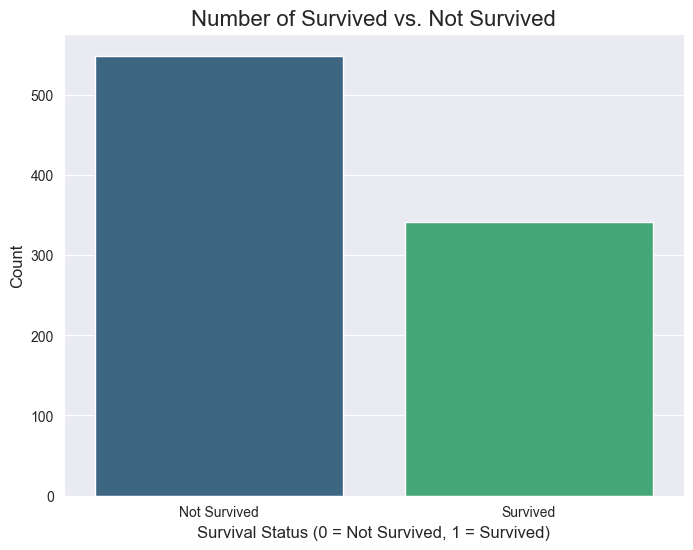

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the counts of Survived and Not Survived
plt.figure(figsize=(8, 6))
sns.countplot(x=target, palette="viridis")
plt.title("Number of Survived vs. Not Survived", fontsize=16)
plt.xlabel("Survival Status (0 = Not Survived, 1 = Survived)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Not Survived', 'Survived'], fontsize=10)
plt.show()

C:\Users\Abdelrahman Mostafa\AppData\Local\Temp\ipykernel_13360\3752224650.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_upsampled['Survived'], palette="viridis")


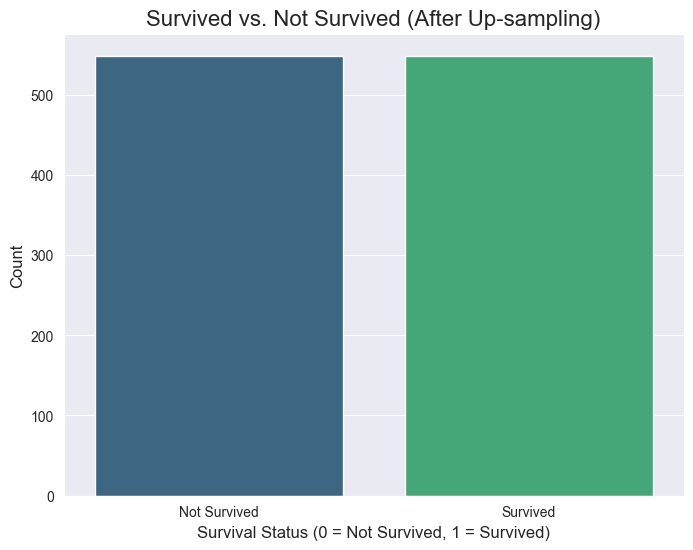

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df_upsampled['Survived'], palette="viridis")
plt.title("Survived vs. Not Survived (After Up-sampling)", fontsize=16)
plt.xlabel("Survival Status (0 = Not Survived, 1 = Survived)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Not Survived', 'Survived'], fontsize=10)
plt.show()

In [8]:
# Define the Random Forest model with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
# Create the pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])
#Define the knn model with balanced class weights
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
# Create the pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_model)
])
# Fit the pipeline
rf_pipeline.fit(xtrain, ytrain)
knn_pipeline.fit(xtrain, ytrain)

# Make predictions
rf_y_pred = rf_pipeline.predict(xtest)
knn_y_pred = knn_pipeline.predict(xtest)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Random Forest Model:")
print("Precision:", precision_score(ytest, rf_y_pred))
print("Recall:", recall_score(ytest, rf_y_pred))
print("F1 Score:", f1_score(ytest, rf_y_pred))
print("\nKNN Model:")
print("Precision:", precision_score(ytest, knn_y_pred))
print("Recall:", recall_score(ytest, knn_y_pred))
print("F1 Score:", f1_score(ytest, knn_y_pred))


Random Forest Model:
Precision: 0.8524590163934426
Recall: 0.9454545454545454
F1 Score: 0.896551724137931

KNN Model:
Precision: 0.7647058823529411
Recall: 0.9454545454545454
F1 Score: 0.8455284552845529


In [10]:
# Evaluate the model
print("Random Forest Model:")
accuracy = rf_pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")
print("\nKNN Model:")
accuracy = knn_pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")


Random Forest Model:
Accuracy on test set: 0.89

KNN Model:
Accuracy on test set: 0.83


In [11]:
#Actual VS Predicted
rf_results_df = pd.DataFrame({
    'Actual': ytest,
    'Predicted': rf_y_pred
})

print("Actual vs Predicted Values (Random Forest Model):")
print(rf_results_df)

knn_results_df = pd.DataFrame({
    'Actual': ytest,
    'Predicted': knn_y_pred
})

print("\nActual vs Predicted Values (KNN Model):")
print(knn_results_df)

Actual vs Predicted Values (Random Forest Model):
     Actual  Predicted
380       1          1
141       1          1
283       1          1
143       0          0
480       0          0
..      ...        ...
148       0          0
600       1          1
836       0          0
180       0          0
192       1          1

[330 rows x 2 columns]

Actual vs Predicted Values (KNN Model):
     Actual  Predicted
380       1          1
141       1          1
283       1          1
143       0          0
480       0          1
..      ...        ...
148       0          0
600       1          1
836       0          0
180       0          0
192       1          1

[330 rows x 2 columns]


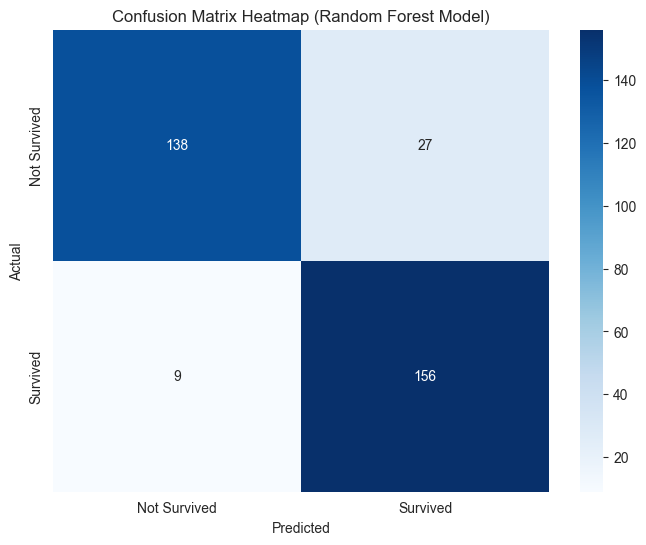

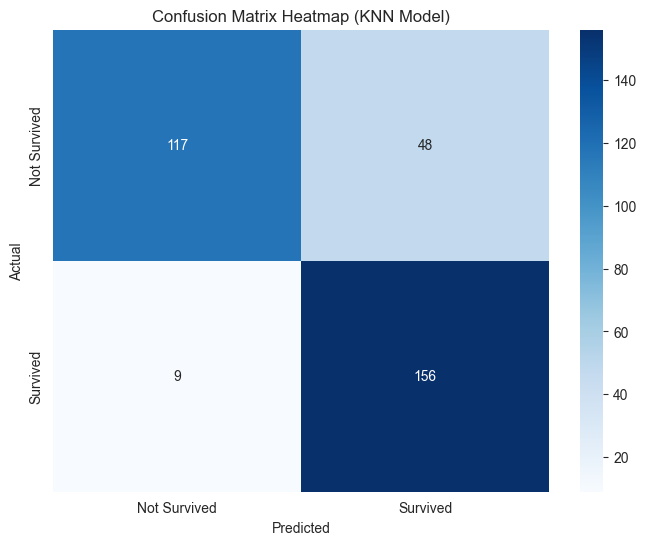

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
rf_cm = confusion_matrix(ytest, rf_y_pred)
knn_cm = confusion_matrix(ytest, knn_y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Random Forest Model)')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (KNN Model)')
plt.show()


In [13]:
from sklearn.metrics import classification_report

# Generate a classification report
rf_report = classification_report(ytest, rf_y_pred)
knn_report = classification_report(ytest, knn_y_pred)

print("Random Forest Model:")
print(rf_report)
print("\nKNN Model:")
print(knn_report)


Random Forest Model:
              precision    recall  f1-score   support

           0       0.94      0.84      0.88       165
           1       0.85      0.95      0.90       165

    accuracy                           0.89       330
   macro avg       0.90      0.89      0.89       330
weighted avg       0.90      0.89      0.89       330


KNN Model:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80       165
           1       0.76      0.95      0.85       165

    accuracy                           0.83       330
   macro avg       0.85      0.83      0.82       330
weighted avg       0.85      0.83      0.82       330



In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
#print evaluation metrics
print("Random Forest Model:")
print("Mean Absolute Error:", mean_absolute_error(ytest, rf_y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(ytest, rf_y_pred)))
print("R2 Score:", r2_score(ytest, rf_y_pred))
print("\nKNN Model:")
print("Mean Absolute Error:", mean_absolute_error(ytest, knn_y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(ytest, knn_y_pred)))
print("R2 Score:", r2_score(ytest, knn_y_pred))

Random Forest Model:
Mean Absolute Error: 0.10909090909090909
Root Mean Squared Error: 0.3302891295379082
R2 Score: 0.5636363636363637

KNN Model:
Mean Absolute Error: 0.17272727272727273
Root Mean Squared Error: 0.41560470729681676
R2 Score: 0.3090909090909091


<Figure size 1200x600 with 0 Axes>

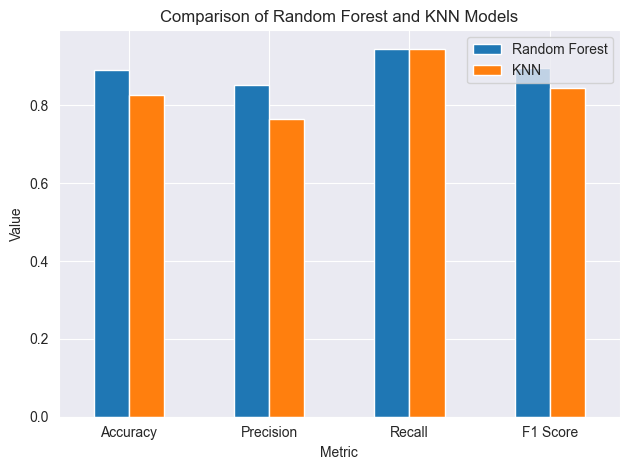

In [15]:
# Plot model comparison
plt.figure(figsize=(12, 6))
comparison = pd.DataFrame({
    'Random Forest': [accuracy_score(ytest, rf_y_pred), precision_score(ytest, rf_y_pred), recall_score(ytest, rf_y_pred), f1_score(ytest, rf_y_pred)],
    'KNN': [accuracy_score(ytest, knn_y_pred), precision_score(ytest, knn_y_pred), recall_score(ytest, knn_y_pred), f1_score(ytest, knn_y_pred)]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
comparison.plot(kind='bar')
plt.title('Comparison of Random Forest and KNN Models')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Recommend using Random Forest model as it has higher accuracy, precision, recall, and F1 score compared to the KNN model.